
<a id='chap-tpdeeplearning1'></a>

# Travaux pratiques - Premiers réseaux de neurones

Au cours de cette séance de travaux pratiques, vous allez être amenés à implémenter vous-même l’apprentissage d’un réseau de neurones simple. Bien que de nombreuses bibliothèques existent pour automatiser cette tâche, il est très utile de se familiariser avec les concepts fondamentaux au moins une fois. Cela vous permettra d’avoir une meilleure compréhension des outils que nous utiliserons plus tard, comme Keras.

## Jeu de données MNIST

Lors de cette séance, nous allons utiliser la base de données MNIST, composée de 70 000 images de chiffres manuscrits en noir et blanc (60 000 pour l’entraînement et 10 000 pour le test). L’objectif est de développer un modèle capable d’identifier automatiquement le chiffre à partir de chaque image.

Pour commencer, nous allons importer les données. Étant donné qu’il s’agit d’un jeu de données largement utilisé et standard, il est intégré dans plusieurs bibliothèques, comme Keras, ce qui nous permet de l’importer facilement en une seule ligne de code :

In [59]:
!pip install --upgrade tensorflow keras numpy scipy

  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)


In [60]:
!python -c "import sys; print(sys.executable)"

/home/florian-andr/anaconda3/envs/jpn_florian/bin/python


In [61]:
#!pip show numpy
import tensorflow as tf
from keras import backend as K

In [62]:
import keras
# Import de MNIST depuis Keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# Transformation des images 28x28 en vecteur de dimension 784
X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')
# Normalisation entre 0 et 1
X_train /= 255
X_test /= 255

# Affichage du nombre de'exemples
print(f"{X_train.shape[0]} exemples d'apprentissage")
print(f"{X_test.shape[0]} exemples de test")

60000 exemples d'apprentissage
10000 exemples de test


## Question

Afficher à l’aide de matplotlib les premières images du jeu d’apprentissage. La fonction `plt.imshow()` (cf. [sa documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)) peut vous être utile.

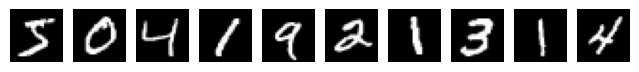

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

n_images = 10
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## Question :

Quel est l’espace dans lequel se trouvent les images ? Quelle est sa dimension ?

In [64]:
X_train.shape

(60000, 784)

## Régression logistique

### Modèle de prédiction

Nous allons implémenter un modèle de classification linéaire simple : la régression logistique. Concrètement, la régression logistique est équivalente à un réseau de neurones à une seule couche. Il s’agit d’une projection du vecteur d’entrée $ \mathbf{x_i} $ par un vecteur de paramètres $ \mathbf{w_{c}} $, plus un biais sclaaire $ b_c $, pour chaque classe.  Le schéma ci-dessous illustre le modèle de régression logistique avec un réseau de neurones.

<img src="LR.png" style="height:150px;" align="center">

En l’occurrence, pour MNIST $ \mathbf{x}_i $ est de dimension 784 et il y a dix chiffres possibles, donc 10 classes différentes. Dans notre cas, on considère que l’image d’entrée est représentée sous sa forme « aplatie », c’est-à-dire un vecteur (1, 784).

Pour simplifier les notations, on regroupe l’ensemble des jeux de paramètres $ \mathbf{w_{c}} $ pour les 10 classes possibles dans une unique matrice $ \mathbf{W} $ de dimensions $ 784\times 10 $. De la même façon, les biais sont regroupés dans un vecteur $ \mathbf{b} $ de longueur 10. La sortie de la régression logistique est un vecteur contenant une activation pour chaque classe, c’est-à-dire $ \mathbf{\hat{s_i}} =\mathbf{x_i}  \mathbf{W}  + \mathbf{b} $ de dimensions (1, 10).

Afin de transformer les activations en de sortie en probabilités pour une distribution catégorielle, on ajoute une fonction d’activation de *softmax* sur $ \mathbf{\hat{y_i}} = \sigma(\mathbf{s_i}) $. Cela nous permet d’obtenir en sortie un vecteur de prédictions $ \mathbf{\hat{y_i}} $, de dimensions (1, 10),  qui représente la probabilité *a posteriori* $ p(\mathbf{\hat{y_i}} | \mathbf{x_i}) $ pour chacune des 10 classes :


<a id='equation-softmax'></a>
$$
p(\hat{y}_{c,i} | \mathbf{x_i}) ) = \frac{e^{\langle \mathbf{x_i} ; \mathbf{w_{c}}\rangle + b_{c}}}{\sum_{c'=1}^{10} e^{\langle \mathbf{x_i} ; \mathbf{w_{c'}}\rangle + b_{c'}}} \tag{1}
$$

### Question

Quel est le nombre de paramètres du modèle utilisé ? Justifier le calcul.

"784 * 10 + 10 = 7850 paramètres"

### Formulation du problème d’apprentissage

Pour entraîner le réseau de neurones, c’est-à-dire déterminer les valeurs optimales des paramètres $ \mathbf{W} $ et $ \mathbf{b} $, on va comparer pour chaque exemple d’apprentissage la sortie prédite $ \mathbf{\hat{y_i}} $ (équation [(1)](#equation-softmax)) pour l’image $ \mathbf{x_i} $ à la sortie réelle $ \mathbf{y_i^*} $ (vérité terrain issue de la supervision). Dans notre cas, on choisit d’encoder la catégorie de l’image $ \mathbf{x_i} $ sous forme *one-hot*, c’est-à-dire :


<a id='equation-one-hot'></a>
$$
y_{c,i}^* =
 \begin{cases}
   1 & \text{si c correspond à l'indice de la classe de } \mathbf{x_i}  \\
   0 & \text{sinon}
 \end{cases} \tag{2}
$$

Générons les étiquettes (*labels*) au format *one-hot* ([(2)](#equation-one-hot)) à l’aide de la fonction `to_categorical` (cf. [documentation de Keras](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)).

In [65]:
from keras.utils import to_categorical
n_classes = 10
# Conversion des étiquettes (int) au format vectoriel one-hot
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

L’erreur de prédiction sera définie à l’aide de l’entropie croisée (*cross-entropy*). Cette fonction de coût s’applique entre $ \mathbf{\hat{y_i}} $ et $ \mathbf{y_i^*} $ par la formule:
$ \mathcal{L}(\mathbf{\hat{y_i}}, \mathbf{y_i^*}) = -\sum_{c=1}^{10} y_{c,i}^* \log(\hat{y}_{c,i}) = - \log(\hat{y}_{c^*,i}) $, où $ c^* $ correspond à l’indice de la classe donnée par la supervision pour l’image $ \mathbf{x_i} $.

### Note

L’entropie croisée correspond en réalité à la divergence de Kullback-Leiber pour des distributions catégorielles. La divergence KL est une mesure de dissimilarité entre distributions de probabilité. Autrement dit, l’erreur que l’on mesure vise à réduire l’écart entre la distribution réelle des catégories et la distribution prédite.

La fonction de coût finale correspond à l’erreur d’apprentissage, c’est-à-dire la moyenne l’entropie croisée sur l’ensemble de la base d’apprentissage $ \mathcal{D} $ constituée des $ N=60000 $ images :


<a id='equation-ce'></a>
$$
\mathcal{L}_{\mathbf{W},\mathbf{b}}(\mathcal{D})  = - \frac{1}{N}\sum_{i=1}^{N} \log(\hat{y}_{c^*,i}) \tag{3}
$$

### Optimisation du modèle

Nous allons minimiser la fonction de coût à l’aide de l’algorithme de descente de gradient appliqué sur les paramètres $ \mathbf{W} $ et $ \mathbf{b} $ du modèle de régression logistique. Pour ce faire, nous allons avoir besoin des gradients de l’entropie croisée par rapport à $ \mathbf{W} $ ainsi que $ \mathbf{b} $. Nous pouvons nous appuyer sur la des dérivées chaînées (*chain rule*, ou théorème de dérivation des fonctions composées) :

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{W}}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{b}}
$$

### Implémentation de l’apprentissage

Les gradients obtenus par les équations du gradients s’écrivent sous forme « vectorielle », ce qui rend les calculs efficaces avec des bibliothèques de calcul scientifique telles que `numpy`. Après calcul du gradient, les paramètres sont mis à jour de la façon suivante :


<a id='equation-gradientupdatew'></a>
$$
\mathbf{W}^{(t+1)} = \mathbf{W}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{W}} \tag{6}
$$


<a id='equation-gradientupdateb'></a>
$$
\mathbf{b}^{(t+1)} = \mathbf{b}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{b}} \tag{7}
$$

où $ \eta $ est le pas de gradient (*learning rate*).

En théorie, la descente de gradient nécessite de calculer les gradients de la fonction de coût sur tout le jeu de données d’apprentissage. Toutefois, ce jeu de données est assez grand et les gradients peuvent être longs à calculer. En pratique, on implémente plutôt une descente de gradient *stochastique*, c’est à dire que les gradients aux équations [(4)](#equation-gradientw) et [(5)](#equation-gradientb) ne seront pas calculés sur l’ensemble des $ N=60000 $ images d’apprentissage, mais sur un sous-ensemble de $ n $ images appelé *batch* ou *lot*. Cette technique permet une mise à jour des paramètres plus fréquente qu’avec une descente de gradient classique, un temps de calcul réduit et une convergence plus rapide, au détriment d’une approximation du gradient.

Le code ci-dessous décrit le squelette de l’algorithme de descente de gradient qui va permettre l’optimisation des paramètres du modèle :

Ce dessous quelques indices :

---

## **🔹 Explication du code**
Le programme entraîne un **modèle de classification linéaire** en utilisant **la descente de gradient par mini-batch**. Il apprend à **prédire des classes** à partir de données d'entrée en utilisant une **fonction de perte cross-entropy** et une **fonction d'activation softmax**.

### **1️⃣ Forward Pass (Prédiction)**
On calcule les scores bruts des classes :
$$
\text{logits} = XW + b
$$
Puis, on applique la **fonction softmax** pour obtenir des probabilités.

### **2️⃣ Calcul de la perte (Cross-Entropy)**
- On transforme les étiquettes (`y_batch`) en **one-hot encoding**.
- On utilise la **perte d'entropie croisée** :
  $$
  \text{Perte} = -\frac{1}{N} \sum_{i} y_i \log(\hat{y}_i)
  $$

### **3️⃣ Backward Pass (Calcul des gradients)**
- Le gradient de la perte par rapport aux logits est donné par :
  $$
  dL/d\hat{Y} = \hat{Y} - Y_{\text{one-hot}}
  $$
- Ensuite, on calcule les gradients par rapport à **W** et **b**.

### **4️⃣ Mise à jour des paramètres (Descente de Gradient)**
- On met à jour `W` et `b` en soustrayant le gradient multiplié par le **taux d'apprentissage (eta)**.

#### ** --> Formules des gradients de W et b**  

##### **Gradient par rapport à W (gradW)**
$$
\frac{\partial L}{\partial W} = \frac{1}{m} X^T (\hat{Y} - Y)
$$

- $ X^T $ est la transposée de la matrice des entrées.  
- $ (\hat{Y} - Y) $ représente la différence entre la prédiction et la vraie étiquette.

##### **Gradient par rapport à b (gradb)**
$$
\frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{Y}_i - Y_i)
$$
- Il s'agit simplement de la somme des erreurs sur chaque échantillon du batch.

---

#### **📌 Mise à jour des paramètres**
Une fois les gradients calculés, on met à jour les paramètres via la **descente de gradient** :
$$
W = W - \eta \frac{\partial L}{\partial W}
$$
$$
b = b - \eta \frac{\partial L}{\partial b}
$$

où $ \eta $ est le **taux d'apprentissage** (learning rate).

##### **✅ Résumé**
| Gradient | Formule mathématique |
|----------|---------------------|
| $ \frac{\partial L}{\partial W} $ | $ \frac{1}{m} X^T (\hat{Y} - Y) $ |
| $ \frac{\partial L}{\partial b} $ | $ \frac{1}{m} \sum (\hat{Y} - Y) $ |
| Mise à jour de $ W $ | $ W = W - \eta \cdot \frac{\partial L}{\partial W} $ |
| Mise à jour de $ b $ | $ b = b - \eta \cdot \frac{\partial L}{\partial b} $ |

In [66]:
import numpy as np
N, d = X_train.shape # N exemples, dimension d
W = np.zeros((d, n_classes)) # initialisation de poids
b = np.zeros((1, n_classes)) # initialisation des biais

n_epochs = 20 # Nombre d'epochs de la descente de gradient
eta = 1e-1 # Learning rate (pas d'apprentissage)
batch_size = 100 # Taille du lot
n_batches = int(float(N) / batch_size)

# On alloue deux matrices pour stocker les valeurs des gradients
gradW = np.zeros((d, n_classes))
gradb = np.zeros((1, n_classes))

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        # ********* À compléter **********
        # Sélection du mini-batch
        start = batch_idx * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]  # Sélection des entrées du mini-batch
        y_batch = y_train[start:end]  # Sélection des labels du mini-batch

        # ---- FORWARD PASS ----
        logits = X_batch @ W + b  # Calcul des scores bruts (logits)
        softmax_probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True) # Conversion en probabilités

        # ---- CALCUL DE LA PERTE (CROSS-ENTROPY) ----
        one_hot_y = np.eye(n_classes)[y_batch]  # Conversion des labels en one-hot encoding
        y_log_y_pred = one_hot_y * np.log(softmax_probs + 1e-9) # Ajout d'un petit terme pour éviter log(0)
        loss = -np.sum(y_log_y_pred) / batch_size

        # ---- BACKWARD PASS ----
        dL_dlogits = softmax_probs - one_hot_y  # Gradient de la perte par rapport aux logits
        gradW = np.dot(X_batch.T, dL_dlogits) / batch_size  # Gradient par rapport à W
        gradb = np.sum(dL_dlogits, axis=0, keepdims=True) / batch_size  # Gradient par rapport à b
        
        # ---- MISE À JOUR DES PARAMÈTRES ----
        W -= eta * gradW
        b -= eta * gradb

### Question

Compléter ce code. Vous devez notamment :

> - Écrire une fonction `forward(batch, W, b)` qui calcule la prédiction (vecteur de sortie $ \hat{\mathbf{y}} $ pour chaque exemple d’un batch de données. Si on considère un batch des données de taille $ tb\times 784 $, les paramètres $ \mathbf{W} $ (taille $ 784\times 10 $) et $ \mathbf{b} $ (taille $ 1\times 10 $), la fonction `forward` renvoie la prédiction $ \mathbf{\hat{Y}} $ sur le batch (taille $ tb\times 10 $).  La fonction `forward` sera appelée pour chaque itération de la double boucle précédente.  
- Completer la fonction `softmax` ci-dessous pour calculer le résultat du passage du softmax sur chaque élément de de la matrice de la projection linéraire (taille $ tb\times 10 $) :  

In [67]:
def forward(X_batch, W, b ):
    
    logits = X_batch @ W + b
    
    return logits

In [68]:
def softmax(X):
     # Entrée: matrice X de dimensions batch x d
     # Sortie: matrice de mêmes dimensions
     softmax_probs = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True) # Conversion en probabilités
     return softmax_probs


- 
  <dl style='margin: 20px 0;'>
  <dt>réecrire le code d'avant avec les deux nouvelles fonctions</dt>
  
  </dl>

In [69]:
import numpy as np
N, d = X_train.shape # N exemples, dimension d
W = np.zeros((d, n_classes)) # initialisation de poids
b = np.zeros((1, n_classes)) # initialisation des biais

n_epochs = 20 # Nombre d'epochs de la descente de gradient
eta = 1e-1 # Learning rate (pas d'apprentissage)
batch_size = 100 # Taille du lot
n_batches = int(float(N) / batch_size)

# On alloue deux matrices pour stocker les valeurs des gradients
gradW = np.zeros((d, n_classes))
gradb = np.zeros((1, n_classes))

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        # ********* À compléter **********
        # Sélection du mini-batch
        start = batch_idx * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]  # Sélection des entrées du mini-batch
        y_batch = y_train[start:end]  # Sélection des labels du mini-batch

        # ---- FORWARD PASS ----
        logits = forward(X_batch, W, b)  # Calcul des scores bruts (logits)
        softmax_probs = softmax(logits) # Conversion en probabilités

        # ---- CALCUL DE LA PERTE (CROSS-ENTROPY) ----
        one_hot_y = np.eye(n_classes)[y_batch]  # Conversion des labels en one-hot encoding
        y_log_y_pred = one_hot_y * np.log(softmax_probs + 1e-9) # Ajout d'un petit terme pour éviter log(0)
        loss = -np.sum(y_log_y_pred) / batch_size

        # ---- BACKWARD PASS ----
        dL_dlogits = softmax_probs - one_hot_y  # Gradient de la perte par rapport aux logits
        gradW = np.dot(X_batch.T, dL_dlogits) / batch_size  # Gradient par rapport à W
        gradb = np.sum(dL_dlogits, axis=0, keepdims=True) / batch_size  # Gradient par rapport à b
        
        # ---- MISE À JOUR DES PARAMÈTRES ----
        W -= eta * gradW
        b -= eta * gradb

### Question

Évaluer les performances du modèle de régression logistique entraîné sur MNIST. On utilisera le taux de bonne classification (*accuracy*) comme métrique. Commencer par mesurer l’évolution des performances du modèle au cours de l’apprentissage (calcul de l'*accuracy* à chaque époque), puis évaluer sur le modèle sur la base de test. Vous pouvez utiliser la [fonction de scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ou la fonction `accuracy` ci-dessous (qui effectue également la phase de prédiction).

**Vous devriez obtenir un score de l’ordre de 92% sur la base de test pour ce modèle de régression logistique.**

In [70]:
def accuracy(W, b, images, labels):
    """ W: matrice de paramètres
        b: vecteur de biais
        images: images de MNIST
        labels: étiquettes de MNIST pour les images

        Renvoie l'accuracy du modèle (W, b) sur les images par rapport aux labels
    """
    pred = forward(images, W, b)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0.,1.).mean()

In [71]:
accuracy(W, b, X_test, Y_test)

0.9224

##### Utilise le package sklearn pour entraîner un MLP (avec la même architecture que le réseau précédent) ainsi qu’un SVM. Évalue ensuite les deux modèles et compare les résultats obtenus avec ceux du modèle précédent.

In [ ]:
#Essai avec MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


clf = MLPClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy avec MLP : ", accuracy)


Accuracy avec MLP :  0.9767


In [ ]:
#Essai avec SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy avec SVM :", accuracy)


/home/florian-andr/anaconda3/envs/jpn_florian/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy avec SVM : 0.7962


On remarque que sur les 3 modèles, le premier (réseau de neurones avec Régression logistique) a l'accuracy la moins élevée (0.92) mais il est le plus rapide à entraîner (moins de 30 secondes)
Le modèle avec SVM a l'accuracy la plus élevée (0,9792) mais c'est aussi le plus long à entraîner (plus de 4 minutes)